In [131]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import glob
import dask.dataframe as dd
import seaborn as sns
import pickle
import pysam
import numpy as np
from collections import defaultdict
from sequencing_tools.viz_tools import color_encoder, okabeito_palette
from sequencing_tools.fastq_tools import reverse_complement
from sklearn.metrics import mean_squared_error
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize = 25)
plt.rc('ytick', labelsize = 25)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})


def expected_nuc():
    fa = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')
    nuc_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for ref in fa.references:
        seq = fa[ref]
        read1 = seq[:15]
        read2 = reverse_complement(seq)[:15]
    
        for i, (b, rb) in enumerate(zip(read1, read2)):
            nuc_dict['read1'][i][b] += 1
            nuc_dict['read2'][i][rb] += 1
            
    dfs = []
    for read, read_dict in nuc_dict.items():
        for pos, pos_dict in read_dict.items():
            dfs.append(pd.DataFrame({'base': list(pos_dict.keys()),
                         'expected_base_count':list(pos_dict.values())})\
                .assign(end = read, pos = pos))
    return pd.concat(dfs) \
        .assign(expected_base_fraction = lambda d: d.groupby(['end','pos']).expected_base_count.transform(lambda x: x/x.sum()))

In [132]:
def count_to_nuc(miR_count_dict):
    '''
    input:
    counts: dict(miRNA:counts[:])
    
    output:
    table:
        pd.DataFrame(pos[:], base[:], counts[:])
    '''
    
    fa = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')
    nuc_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for ref in fa.references:
        seq = fa[ref]
        read1 = seq[:15]
        read2 = reverse_complement(seq)[:15]
    
        for i, (b, rb) in enumerate(zip(read1, read2)):
            nuc_dict['read1'][i][b] += miR_count_dict[ref]
            nuc_dict['read2'][i][rb] += miR_count_dict[ref]

    dfs = []
    for read, read_dict in nuc_dict.items():
        for pos, pos_dict in read_dict.items():
            dfs.append(pd.DataFrame({'base': list(pos_dict.keys()),
                         'base_count':list(pos_dict.values())})\
                .assign(end = read, pos = pos))
            
    return pd.concat(dfs) \
        .assign(base_fraction = lambda d: d.groupby(['end','pos']).base_count.transform(lambda x: x/x.sum()))    

In [133]:
NTA=''
project_path = '/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR'
table_name = project_path + '/mir_count{NTA}.feather'.format(NTA=NTA)
df = pd.read_feather(table_name)\
    .filter(regex='mir|NTT[0-9]+_corrected')
df.to_csv(table_name.replace('.feather','.csv'),
            index=False, sep=',')
df.head()

,mir,NTT1_corrected,NTT2_corrected,NTT3_corrected
0,EBV-1-1,233.689718,374.269162,219.938572
1,EBV-1-2,10419.285019,10342.744944,10829.625327
2,EBV-1-2-star,1261.663518,1091.894084,1132.482519
3,EBV-1-3,862.623651,841.530345,879.954851
4,EBV-1-3P,1287.042822,1139.432839,1722.775951


In [134]:
NTA=''
project_path = '/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR'
df = pd.read_feather(project_path + '/mir_count{NTA}.feather'.format(NTA=NTA)) \
    .fillna(0)\
    .pipe(pd.melt, id_vars = 'mir', var_name = 'sn', value_name = 'mir_count') \
    .pipe(lambda d: d[d.sn.str.contains('NTT')])  \
    .assign(process = lambda d: np.where(d.sn.str.contains('corrected'),
                                        'After reweighting',
                                        'Before reweighting'))\
    .groupby(['mir','process'], as_index=False)\
    .agg({'mir_count':'sum'})
df.head()

,mir,process,mir_count
0,EBV-1-1,After reweighting,5280.633736
1,EBV-1-1,Before reweighting,2678.000000
2,EBV-1-2,After reweighting,54004.352996
3,EBV-1-2,Before reweighting,72583.000000
4,EBV-1-2-star,After reweighting,7497.555389


In [135]:
dfs = []
for sn, sn_df in df.groupby('process'):
    mir_dict = {m:c for m, c in zip(sn_df.mir, sn_df.mir_count)}
    mir_d = count_to_nuc(mir_dict) \
        .assign(process = sn)
    dfs.append(mir_d)
mir_df = pd.concat(dfs)  \
    .merge(expected_nuc(), on=['base','pos','end']) \
    .assign(fraction = lambda d: d.base_fraction/d.expected_base_fraction)  \
    .assign(end = lambda d: d.end.str.capitalize()) \
    .assign(pos = lambda d: d.pos + 1)\
    .query('pos < 7') \
    .assign(pos = lambda d: np.where(d.end=="Read2", 7-d.pos,d.pos)) \
    .assign(base = lambda d: np.where(d.end=="Read2", [reverse_complement(b) for b in d.base],d.base))\
    .assign(base = lambda d: d.base.str.replace('T','U')) 
mir_df.head()

,base,base_count,end,pos,base_fraction,process,expected_base_count,expected_base_fraction,fraction
0,U,2.825800e+07,Read1,1,0.519284,After reweighting,402,0.417879,1.242665
1,U,4.657823e+07,Read1,1,0.584805,Before reweighting,402,0.417879,1.399459
2,A,9.914461e+06,Read1,1,0.182193,After reweighting,284,0.295218,0.617148
3,A,1.189265e+07,Read1,1,0.149316,Before reweighting,284,0.295218,0.505782
4,G,8.848757e+06,Read1,1,0.162610,After reweighting,122,0.126819,1.282216


Plotted ../figures/reweighted_nucleotide.eps


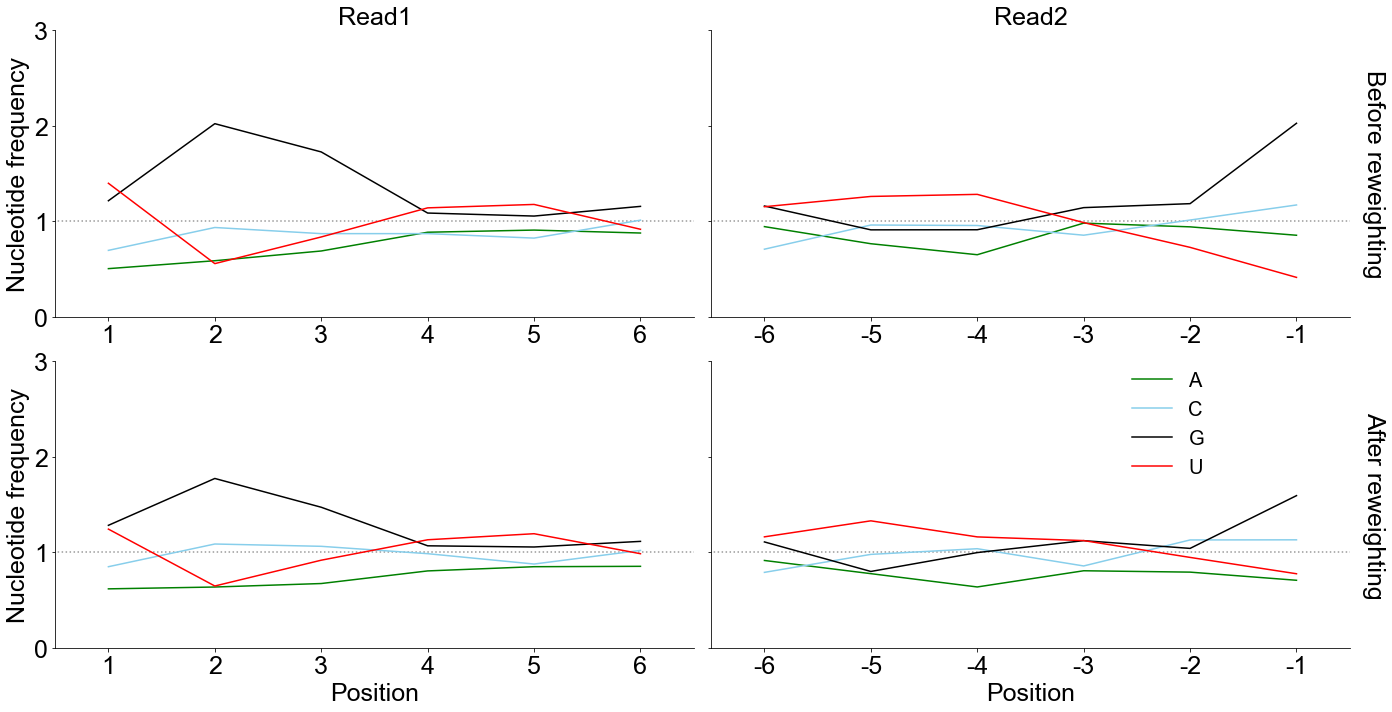

In [136]:
p = sns.FacetGrid(data=mir_df, row='process', hue = 'base',
             palette = ['green','skyblue','black', 'red'],
             col_order = ['Read1','Read2'],
             row_order = ['Before reweighting', 'After reweighting'],
             hue_order = ['A','C','G','U'],
             col= 'end',aspect=2, height=5,
             sharex=False,
             margin_titles=True)
p.map(plt.plot, 'pos', 'fraction')
for i, ax in enumerate(p.fig.axes):
    ax.hlines(xmin=0, xmax=16, y=1,linestyle=':', color='grey', alpha=0.8)
    if i in {1,3}:
        ax.set_xticklabels(range(-7,0))
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=25)
p.add_legend(fontsize=20,title='', bbox_to_anchor=(0.8,0.4))
p.set_axis_labels('Position', 'Nucleotide frequency')
p.set(xlim=(.5,6.5), ylim=(0,3))
figname = '../figures/reweighted_nucleotide{NTA}.eps'.format(NTA=NTA)
p.savefig(figname, bbox_inches='tight')
print('Plotted %s' %figname)

In [56]:
with open('model/weights.pkl', 'rb') as index:
    weights = pickle.load(index)

In [57]:
pd.Series(list(weights.values())).describe()

count    65536.000000
mean         3.564368
std          3.398795
min          0.135888
25%          1.111366
50%          2.587982
75%          4.832247
max         32.791750
dtype: float64

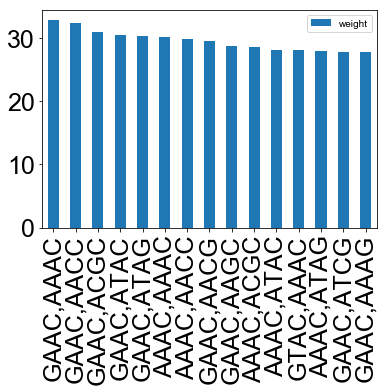

In [58]:
pd.DataFrame().from_dict(weights, orient='index', columns=['weight']) \
    .nlargest(15, 'weight')\
    .plot.bar()

In [59]:
NTA = '.no_NTA'
NTA=''
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR/mir_count{NTA}.feather'.format(NTA=NTA))
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,mir,MTT1_corrected,MTT1_filter,MTT2_corrected,MTT2_filter,MTT3_corrected,MTT3_filter,NTC1_corrected,NTC1_filter,NTC2_corrected,...,NTT3_corrected,NTT3_filter,NTT6N_corrected,NTT6N_filter,NTTR1_corrected,NTTR1_filter,NTTR2_corrected,NTTR2_filter,NTTR3_corrected,NTTR3_filter
0,EBV-1-1,382.726393,155.0,410.799366,281.0,431.296611,296.0,232.401104,140.0,146.336318,...,209.145750,137.0,211.041057,121.0,1160.309772,545.0,835.119360,489.0,2029.398786,1122.0
1,EBV-1-2,5481.213245,7488.0,6494.166878,9065.0,7256.003066,9780.0,7625.338110,10546.0,7516.003645,...,10462.272194,14587.0,6347.142266,9487.0,5757.539157,7017.0,4431.535589,6110.0,5108.774468,7317.0
2,EBV-1-2-star,606.533589,517.0,1030.486903,678.0,1402.749950,975.0,225.493826,193.0,281.714334,...,1088.808257,848.0,942.618011,857.0,874.891248,597.0,831.306390,695.0,1207.920944,921.0
3,EBV-1-3,460.175536,673.0,759.404709,1151.0,772.330613,1196.0,766.961187,1300.0,1029.595157,...,836.262877,1508.0,570.533551,1026.0,241.958988,372.0,354.284717,579.0,450.841922,619.0
4,EBV-1-3P,2123.389370,2017.0,2567.028437,2365.0,3189.191274,3062.0,1408.373529,1244.0,1196.791020,...,1635.063345,1489.0,2137.118517,2081.0,10008.398766,9422.0,7413.135664,7210.0,5544.543736,5076.0


In [60]:
ce = color_encoder()
mir_df = df\
    .set_index('mir')\
    .transform(lambda x: x/x.sum() * 1e6)\
    .reset_index()\
    .fillna(0)\
    .pipe(pd.melt, id_vars='mir', value_name = 'mir_count', var_name = 'sn')\
    .assign(correct = lambda d: np.where(d['sn'].str.contains('corrected'), 'Corrected', 'Uncorrected'))\
    .assign(color = lambda d: ce.fit_transform(d.correct)) 
mir_df.head()

,mir,sn,mir_count,correct,color
0,EBV-1-1,MTT1_corrected,76.697243,Corrected,#56B4E9
1,EBV-1-2,MTT1_corrected,1098.419001,Corrected,#56B4E9
2,EBV-1-2-star,MTT1_corrected,121.547546,Corrected,#56B4E9
3,EBV-1-3,MTT1_corrected,92.217823,Corrected,#56B4E9
4,EBV-1-3P,MTT1_corrected,425.520980,Corrected,#56B4E9


In [73]:
mir_df.query('mir=="EBV-1-1" & correct=="Corrected"')

,mir,sn,mir_count,correct,color
0,EBV-1-1,MTT1_corrected,76.697243,Corrected,#56B4E9
1924,EBV-1-1,MTT2_corrected,61.400493,Corrected,#56B4E9
3848,EBV-1-1,MTT3_corrected,58.368026,Corrected,#56B4E9
5772,EBV-1-1,NTC1_corrected,49.812258,Corrected,#56B4E9
7696,EBV-1-1,NTC2_corrected,31.804714,Corrected,#56B4E9
9620,EBV-1-1,NTC3_corrected,32.062913,Corrected,#56B4E9
11544,EBV-1-1,NTT1_corrected,33.829753,Corrected,#56B4E9
13468,EBV-1-1,NTT2_corrected,53.327493,Corrected,#56B4E9
15392,EBV-1-1,NTT3_corrected,26.993522,Corrected,#56B4E9
17316,EBV-1-1,NTT6N_corrected,23.232950,Corrected,#56B4E9


In [61]:
rmse = mir_df \
    .groupby(['sn','correct','color'], as_index=False)\
    .agg({'mir_count': lambda x: mean_squared_error(np.log([1e6/962+1]*len(x)), 
                                                    np.log(x+1)) })\
    .assign(sn = lambda d: d.sn.str.extract('([A-Z]+[0-9]+)_'))\
    .pipe(pd.pivot_table, index=['sn'], columns = 'correct', values='mir_count') \
    .assign(Initial = lambda d: d.Uncorrected - d.Corrected) \
    .drop('Uncorrected', axis=1) \
#    .filter(['Corrected', 'Initial'])\
#    .rename(columns = {'Corrected':'Reweighted reads','Initial':'Intial reads'})

rmse

correct,Corrected,Initial
sn,,
MTT1,2.785823,1.677988
MTT2,2.572990,1.675127
MTT3,2.455856,1.692620
NTC1,3.131374,1.775521
NTC2,4.379015,0.642835
NTC3,4.143314,0.587601
NTT1,3.512412,1.903048
NTT2,3.399540,1.912910
NTT3,3.301710,2.095265


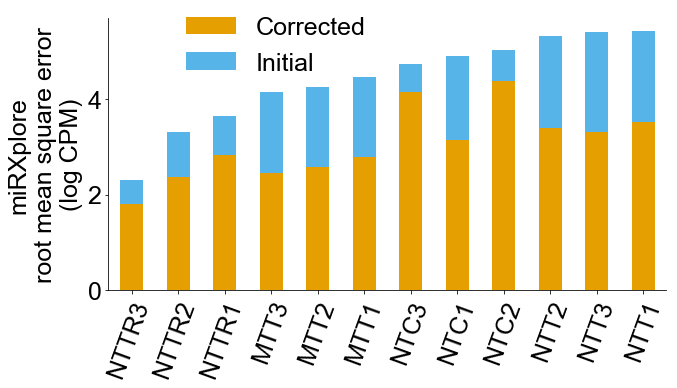

In [62]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot()
rmse_df = rmse\
    .assign(total = lambda d: d.sum(axis=1))\
    .sort_values('total')\
    .drop('total', axis=1)

if NTA ==  '.no_NTA':
    rmse_df['Initial'] = rmse_df['Corrected'] + rmse_df['Initial']
    stacked=False
else:
    stacked=True
rmse_df.plot.bar(stacked=stacked, ax = ax, color = okabeito_palette() )
sns.despine()
ax.legend(fontsize=25, frameon=False, loc='center', bbox_to_anchor=(0.3,0.9))
xts = []
for xt in ax.get_xticklabels():
    xts.append(xt.get_text().split('_')[0])
ax.set_xticklabels(xts, rotation=70, rotation_mode = 'anchor', ha='right')
ax.set_xlabel('')
ax.set_ylabel('miRXplore\nroot mean square error\n(log CPM)')
figname = '../figures/reweighted_rmse{NTA}.pdf'.format(NTA=NTA)
fig.savefig(figname, bbox_inches='tight')

In [63]:
nuc_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR/nuc_count{NTA}.feather'.format(NTA=NTA)) \
    .set_index('pos')\
    .pipe(lambda d: d[d.samplename.str.contains('^NTT[0-9]+')])\
    .assign(corrected = lambda d: np.where(d.samplename.str.contains('corrected'),
                                   'corrected',
                                   'uncorrected'))\
    .assign(samplename = lambda d: d.samplename.str.extract('^([A-Z]+[0-9]+)_'))\
    .pipe(dd.from_pandas, npartitions=24)\
    .groupby(['pos','end','corrected'])\
    .apply(lambda d: d\
               .assign(base_fraction = lambda d: d.base_count/d.base_count.sum())\
               .filter(regex='base'),
          meta = {'base':'f8', 'base_count':'f8', 'base_fraction':'f8'}) \
    .compute()
nuc_df.index = nuc_df.index.droplevel(-1)
nuc_df = nuc_df\
    .reset_index()
nuc_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,pos,end,corrected,base,base_count,base_fraction
0,0,read1,corrected,G,2035.879776,0.016917
1,0,read1,corrected,A,3354.943446,0.027877
2,0,read1,corrected,C,5472.315982,0.045471
3,0,read1,corrected,T,21155.638512,0.175787
4,0,read1,corrected,G,1822.469330,0.015143


In [64]:
expected_nuc().head()

,base,expected_base_count,end,pos,expected_base_fraction
0,T,402,read1,0,0.417879
1,A,284,read1,0,0.295218
2,G,122,read1,0,0.126819
3,C,154,read1,0,0.160083
0,A,356,read1,1,0.370062


In [65]:
corrected_df =  nuc_df\
    .groupby(['corrected','end','pos','base'], as_index=False)\
    .agg({'base_fraction':'sum'}) \
    .sort_values('pos')\
    .reset_index(drop=True)\
    .merge(expected_nuc(), on =['pos','base','end'], how='left' )\
    .assign(end = lambda d: d.end.str.capitalize())\
    .assign(corrected = lambda d: d.corrected.str.capitalize())\
    .assign(pos = lambda d: d.pos + 1)\
    .assign(normalized = lambda d: d.base_fraction / d.expected_base_fraction)\
    .assign(corrected = lambda d: d.corrected.map({'Corrected':'After reweighting','Uncorrected':'Before reweighting'}))\
    .assign(base = lambda d: d.base.str.replace('T','U')) \
    .query('pos < 7') \
    .assign(pos = lambda d: np.where(d.end=="Read2", 7-d.pos,d.pos))
corrected_df.head()

,corrected,end,pos,base,base_fraction,expected_base_count,expected_base_fraction,normalized
0,After reweighting,Read1,1,A,0.100858,284.0,0.295218,0.341639
1,Before reweighting,Read2,6,U,0.193455,220.0,0.228690,0.845926
2,Before reweighting,Read2,6,G,0.203665,179.0,0.186071,1.094557
3,Before reweighting,Read2,6,C,0.550845,205.0,0.213098,2.584941
4,Before reweighting,Read2,6,A,0.052035,358.0,0.372141,0.139826


Plotted ../figures/reweighted_nucleotide.eps


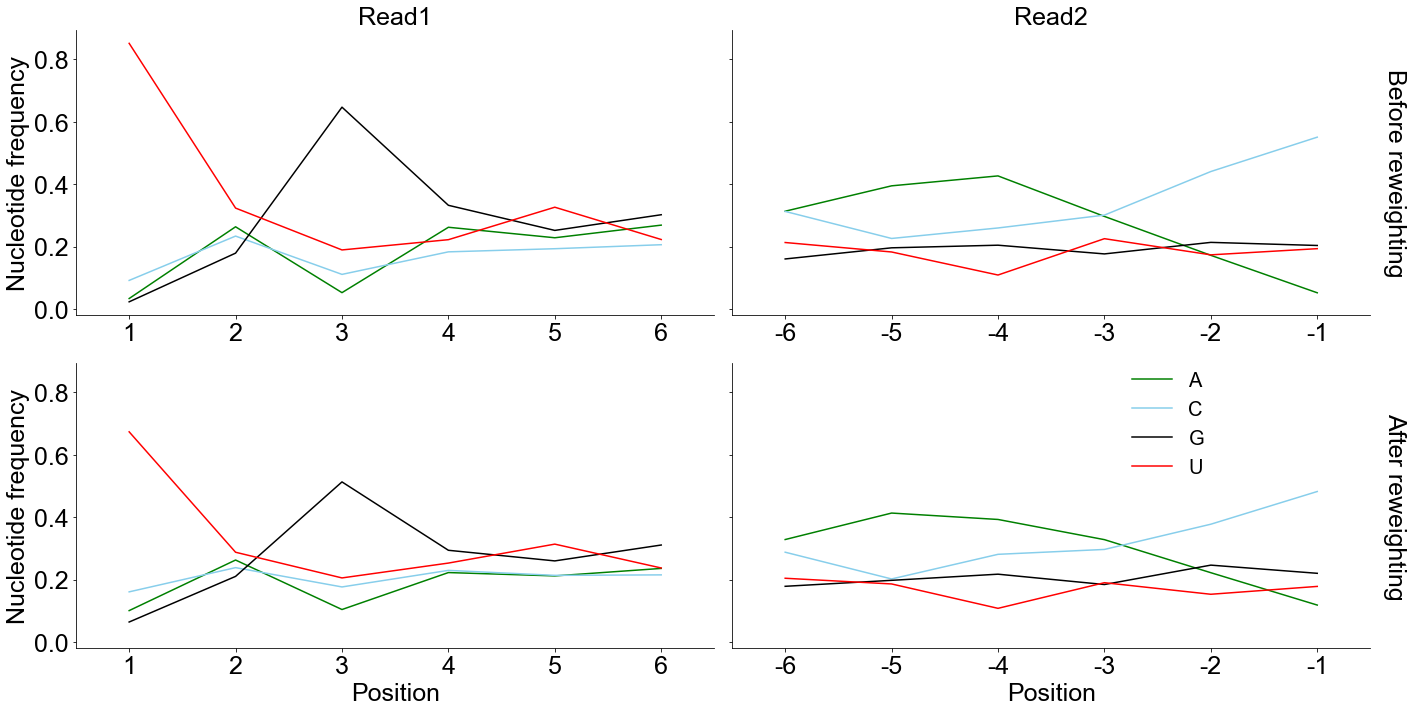

In [68]:
p = sns.FacetGrid(data=corrected_df, row='corrected', hue = 'base',
             palette = ['green','skyblue','black', 'red'],
             col_order = ['Read1','Read2'],
             row_order = ['Before reweighting', 'After reweighting'],
             hue_order = ['A','C','G','U'],
             col= 'end',aspect=2, height=5,
             sharex=False,
             margin_titles=True)
p.map(plt.plot, 'pos', 'base_fraction')
for i, ax in enumerate(p.fig.axes):
#    ax.hlines(xmin=0, xmax=16, y=1,linestyle=':', color='grey', alpha=0.8)
    if i in {1,3}:
        ax.set_xticklabels(range(-7,0))
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=25)
p.add_legend(fontsize=20,title='', bbox_to_anchor=(0.8,0.4))
p.set_axis_labels('Position', 'Nucleotide frequency')
p.set(xlim=(.5,6.5))
figname = '../figures/reweighted_nucleotide{NTA}.eps'.format(NTA=NTA)
p.savefig(figname, bbox_inches='tight')
print('Plotted %s' %figname)

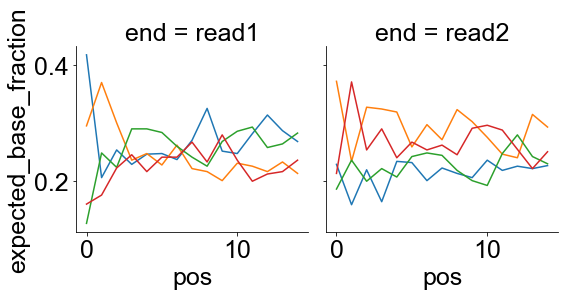

In [393]:
p = sns.FacetGrid(data = expected_nuc(),
             hue = 'base', col = 'end', height=4)
p.map(plt.plot, 'pos','expected_base_fraction')